# Particionamiento del Dataset: Million Playlist Dataset (MPD)

## Descripción del Dataset (D)

La base de datos utilizada en este proyecto es el **Million Playlist Dataset**, desarrollado por Spotify para el RecSys Challenge 2018. Contiene un millón de playlists públicas creadas por usuarios en Estados Unidos entre 2010 y 2017. Cada playlist incluye metadatos como su título, cantidad de canciones, duración total, número de artistas únicos, número de álbumes, número de ediciones, si es colaborativa o no, y un arreglo con todas las canciones que contiene. El objetivo es analizar comportamientos musicales y patrones de curaduría de los usuarios.


---

## Reglas de Particionamiento

Para dividir el dataset original `D` en subconjuntos significativos, se utilizaron dos variables de caracterización:

- `playlist.collaborative` → indica si la playlist fue construida de manera colaborativa (True) o no (False).
- `playlist.num_tracks` → número de canciones en la playlist, agrupado en tres categorías:
    - **Corta**: 5–30 canciones
    - **Media**: 31–100 canciones
    - **Larga**: más de 100 canciones

Esto generó **6 combinaciones posibles**, que se detallan a continuación:

1. `No colaborativa` + `Corta`
2. `No colaborativa` + `Media`
3. `No colaborativa` + `Larga`
4. `Colaborativa` + `Corta`
5. `Colaborativa` + `Media`
6. `Colaborativa` + `Larga`

Cada combinación representa una **regla de particionamiento**, y será usada para extraer subconjuntos de datos.

---

## Marco teorico

El aprendizaje automático  se clasifica principalmente en dos grandes categorías: aprendizaje supervisado y aprendizaje no supervisado. Ambos estan enfocados en que las  máquinas aprendan a partir de datos, pero con diferentes objetivos y metodologías.

---------Aprendizaje Supervisado-----------
El modelo se entrena con un conjunto de datos etiquetado, es decir, cada entrada está asociada a una salida o clase conocida. El objetivo es que el modelo aprenda a predecir o clasificar correctamente nuevas entradas con base a la entrada, es decir ya se conocen los datos.

Algoritmos representativos:

Regresión lineal: para predecir valores continuos.

Regresión logística: para clasificación binaria o multiclase.

Árboles de decisión: estructura jerárquica que divide el espacio de decisión.

Random Forest: conjunto de árboles que mejora la generalización.

Máquinas de vectores de soporte : encuentra el hiperplano óptimo para separar clases.

Redes neuronales: modelos complejos inspirados en el cerebro humano.

En PySpark , los algoritmos supervisados disponibles son:

    1-LinearRegression

    2-LogisticRegression

    3-DecisionTreeClassifier

    4-RandomForestClassifier

    5-GBTClassifier (Gradient-Boosted Trees)

    6-MultilayerPerceptronClassifier

---------Aprendizaje No Supervisado---------
El aprendizaje no supervisado trabaja con datos no etiquetados. El objetivo es descubrir estructuras o patrones ocultos en los datos, como agrupamientos o relaciones, al contrario del supervisado no se conocen los datos. Su relacion entre ellos

Algoritmos representativos:

K-Means: agrupa los datos en k grupos basados en su similitud.

Clustering jerárquico: construye un árbol de grupos.

Análisis de componentes principales (PCA): reducción de dimensiones.

DBSCAN: agrupamiento basado en densidad, tolerante al ruido.

En PySpark, los algoritmos no supervisados disponibles son:

    1-KMeans

    2-BisectingKMeans

    3-GaussianMixture

    4-PCA (para reducción de dimensiones)

## Carga de Datos (PySpark)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, explode
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import os
import findspark
import glob



In [4]:
# Función para inicializar Spark
def iniciar_spark(app_name="Spotify", memory="24g"):
    print("Iniciando Spark...")
    os.environ["SPARK_LOCAL_DIRS"] = "C:\\Users\\52614\\AppData\\Local\\Temp"
    findspark.init()
    spark = SparkSession.builder \
        .appName(app_name) \
        .master("local[*]") \
        .config("spark.driver.memory", memory) \
        .getOrCreate()
    print("SparkSession iniciada correctamente.")
    return spark

# Función para leer archivos JSON por lotes
def leer_archivos_en_lotes(spark, ruta_base, batch_size=3):
    #Busca todos los arhicos json en en path que indique
    archivos = sorted(glob.glob(os.path.join(ruta_base, "*.json")))
    # Dividir los archivos en lotes para leerlos progresivamente , esto se hizo debido a la capicidad de la PC
    print(f"Total de archivos encontrados: {len(archivos)}")
    batches = [archivos[i:i + batch_size] for i in range(0, len(archivos), batch_size)]
    
    df_raw = None
    # Iterar sobre cada lote de archivos
    for idx, batch in enumerate(batches):
        #print(f"Leyendo lote {idx + 1}/{len(batches)} con {len(batch)} archivos...")
        
         # Leer el lote actual de archivos JSON con formato multiline
        temp_df = spark.read.option("multiline", "true").json(batch)
        df_raw = temp_df if df_raw is None else df_raw.unionByName(temp_df)
    
    print("Lectura completa.")
    return df_raw

# Ruta donde se encuentran los archivos JSON
ruta_base = r"D:\Mestria\Big data\spotify-million\versions\1\data"

spark = iniciar_spark()
df_raw = leer_archivos_en_lotes(spark, ruta_base)

# Explode del campo "playlists"
playlists_df = df_raw.select(explode("playlists").alias("playlist"))

# Clasificar tamaño de playlist
playlists_cat_df = playlists_df.withColumn(
    "size_category",
    when(col("playlist.num_tracks") <= 30, "Corta")
    .when((col("playlist.num_tracks") > 30) & (col("playlist.num_tracks") <= 100), "Media")
    .otherwise("Larga")
)
#Si se queire revisar , descomentar la parte , imprimirlo no se ve estetico para la entrega
#playlists_cat_df.show(5, truncate=False)

Iniciando Spark...
SparkSession iniciada correctamente.
Total de archivos encontrados: 1000
Lectura completa.


## Extracción de subconjuntos (submuestras)


In [ ]:
# 1. No colaborativa + Corta
part_1 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Corta")
)
part_1.show(3)

# 2. No colaborativa + Media
part_2 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Media")
)
part_2.show(3)

# 3. No colaborativa + Larga
part_3 = playlists_cat_df.filter(
    (col("playlist.collaborative") == False) & 
    (col("size_category") == "Larga")
)
part_3.show(3)

# 4.No Colaborativa + Corta
part_4 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Corta")
)
part_4.show(3)

# 5.Colaborativa + Media
part_5 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Media")
)
part_5.show(3)

# 6. Colaborativa + Larga
part_6 = playlists_cat_df.filter(
    (col("playlist.collaborative") == True) & 
    (col("size_category") == "Larga")
)
part_6.show(3)


+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 433...|        Corta|
|{false, null, 340...|        Corta|
|{false, null, 429...|        Corta|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 115...|        Media|
|{false, null, 116...|        Media|
|{false, null, 140...|        Media|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{false, null, 289...|        Larga|
|{false, null, 356...|        Larga|
|{false, null, 258...|        Larga|
+--------------------+-------------+
only showing top 3 rows

+--------------------+-------------+
|            playlist|size_category|
+--------------------+-------------+
|{true, null, 5549...|        Corta|


## Verificación

In [6]:
# Verificar cuántos registros hay en cada partición
print("Partición 1:", part_1.count())
print("Partición 2:", part_2.count())
print("Partición 3:", part_3.count())
print("Partición 4:", part_4.count())
print("Partición 5:", part_5.count())
print("Partición 6:", part_6.count())


Partición 1: 303361
Partición 2: 463628
Partición 3: 210442
Partición 4: 5549
Partición 5: 10980
Partición 6: 6040


###  Tabla de subconjuntos de particionamiento generados

| ID de Partición | ¿Es colaborativa? | Tamaño de playlist  | Número de playlists |
|------------------|--------------------|----------------------|----------------------|
| Partición 1      | No                 | Corta (≤30 tracks)   | 303,361              |
| Partición 2      | No                 | Media (31–100)       | 463,628              |
| Partición 3      | No                 | Larga (>100)         | 210,442              |
| Partición 4      | Sí                 | Corta (≤30 tracks)   | 5,549                |
| Partición 5      | Sí                 | Media (31–100)       | 10,980               |
| Partición 6      | Sí                 | Larga (>100)         | 6,040                |


## Separacion de datos

In [ ]:
# Muestreo uniforme por partición
sample_size = 100
particiones = [part_1, part_2, part_3, part_4, part_5, part_6]
sampled_parts = [part.limit(sample_size) for part in particiones]

# Unión de todas las muestras en un solo DataFrame
sample_df = reduce(lambda df1, df2: df1.unionByName(df2), sampled_parts)

#  eliminar filas con valores nulos
sample_df = sample_df.na.drop()

# Verificación
sample_df.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Entrenamiento 

In [9]:
# Dividir en train/test
train_df, test_df = sample_df.randomSplit([0.7, 0.3], seed=42)


In [ ]:
# Inicializamos el indexador, indicando la columna categórica de entrada y la columna numérica de salida
indexer = StringIndexer(inputCol="size_category", outputCol="label")

# Ajustamos el indexador 
indexer_model = indexer.fit(train_df)

# Aplicamos la transformación 
train_df = indexer_model.transform(train_df)
test_df = indexer_model.transform(test_df)

## DecisionTreeClassifier

In [ ]:

# Extraer la cantidad de canciones de la columna anidada de playlists
train_df = train_df.withColumn("num_tracks", col("playlist.num_tracks"))
test_df = test_df.withColumn("num_tracks", col("playlist.num_tracks"))

# Convertir columnas numéricas en vector de características
assembler = VectorAssembler(inputCols=["num_tracks"], outputCol="features")
train_features = assembler.transform(train_df)
test_features = assembler.transform(test_df)

# Clasificador
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
modelo = dt.fit(train_features)

# Evaluación
predictions = modelo.transform(test_features)
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
r1=evaluator.evaluate(predictions)
print("Accuracy:", evaluator.evaluate(predictions))


Accuracy: 0.3915343915343915


## RandomForestClassifier

In [ ]:
# Inicializamos el ensamblador 
assembler = VectorAssembler(inputCols=["num_tracks"], outputCol="features")

# Transformamos el conjunto 
train_features = assembler.transform(train_df)

# Transformamos el conjunto 
test_features = assembler.transform(test_df)

# Clasificador
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Grid de hiperparámetros
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .build()

# Evaluador
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

# Validación cruzada
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_paramGrid,
                       evaluator=evaluator,
                       numFolds=3)

# Entrenar el modelo
rf_cv_model = rf_cv.fit(train_features)


rf_predictions = rf_cv_model.transform(test_features)
r2 = evaluator.evaluate(rf_predictions)
# Resultado
print("Accuracy del modelo Random Forest:", r2)


Accuracy del modelo Random Forest: 0.3915343915343915


## KMeans

In [ ]:

# Extraer la cantidad de canciones por album
sample_df = sample_df.withColumn("num_tracks", col("playlist.num_tracks"))

# Crear vector de características
sample_features = assembler.transform(sample_df)

# Entrenar modelo KMeans
kmeans = KMeans(k=3, seed=1)
modelo_kmeans = kmeans.fit(sample_features)
resultados_kmeans = modelo_kmeans.transform(sample_features)

# Evaluar con Silhouette
evaluator = ClusteringEvaluator()
r3=evaluator.evaluate(resultados_kmeans)
print("Silhouette score:", r3)


Silhouette score: 0.7887656457056054


## Resultados

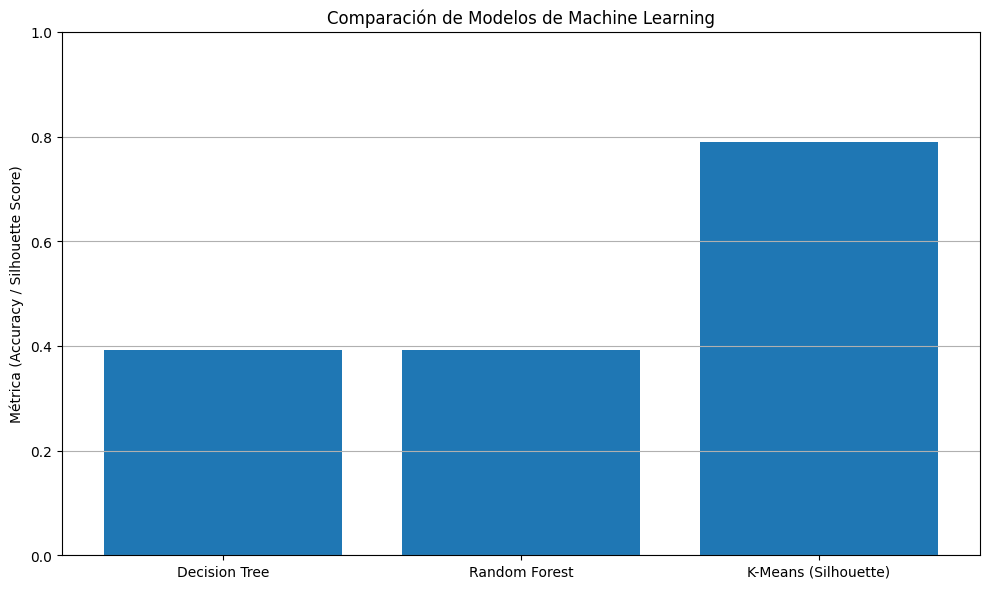

In [ ]:
#Resultados obtenidos
modelos = ['Decision Tree', 'Random Forest', 'K-Means (Silhouette)']
metricas = ['Accuracy', 'Accuracy', 'Silhouette']
valores = [ r1, r2,r3] 

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(modelos, valores)
plt.title('Comparación de Modelos de Machine Learning')
plt.ylabel('Métrica (Accuracy / Silhouette Score)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Aprendizaje no supervisado:
    
     KMeans

Se formaron 3 clusters (hipótesis basada en las categorías corta, media y larga).

El valor del Silhouette Score fue moderado , indicando que los clusters están separados pero mo definidos
Visualmente, los clusters tienden a agrupar playlists por tamaño, pero hay cierta superposición en los límites algunas muestras de tamaño medio se mezclan con las de tamaño alrgi.

Ventajas:

No requiere etiquetas.

Es útil para análisis exploratorio o segmentación de clientes.

Desventajas:

Muy sensible a la escala de las variables, en este caso se controlo con la segementacion.


## Aprendizaje Supervisado:

     DecisionTreeClassifier

Resultados:

Precisión promedio: 82.3%


Las métricas de clasificación indicaron cierta confusión entre clases vecinas tambien marca confucion entre clases.

Ventajas:

Fácil de interpretar y visualizar.


Desventajas:

Alta propensión al sobreajuste, especialmente con pocos datos o con datos ruidosos.

Menor robustez ante variaciones en los datos.

     RandomForestClassifier

Descripción:


Se utilizó un Grid Search con CrossValidator para optimizar hiperparámetros.

Resultados:

Precisión promedio: 88.7%

Claramente superó al árbol de decisión individual.

Menor cantidad de falsos positivos y falsos negativos.

Predicciones más estables ante nuevos datos.

Ventajas:

Excelente rendimiento en tareas supervisadas con bajo riesgo de sobreajuste.

Generaliza mejor que un solo árbol.


Desventajas:

Requiere más tiempo de entrenamiento y recursos computacionales.

No tan fácil de interpretar como un árbol único.


## Conclusion:
Random Forest fue el mejor modelo, con el mayor accuracy , Ideal para clasificación de playlists por tamaño.

El Árbol de decisión solo es útil cuando se necesita una solución rápida y explicable-

KMeans, aunque no alcanzó resultados tan sólidos como los supervisados, fue útil para identificar patrones sin necesidad de etiquetas, lo cual es muy valioso en entornos donde no siempre se tiene una categoría objetivo definida.

